Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3234 - root_mean_squared_error: 2.0565 - val_loss: 0.4896 - val_root_mean_squared_error: 0.6997
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4921 - root_mean_squared_error: 0.7005 - val_loss: 0.2588 - val_root_mean_squared_error: 0.5087
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.3187 - root_mean_squared_error: 0.5643 - val_loss: 0.1808 - val_root_mean_squared_error: 0.4252
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2266 - root_mean_squared_error: 0.4755 - val_loss: 0.1333 - val_root_mean_squared_error: 0.3650
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.1803 - root_mean_squared_error: 0.4245 - val_loss: 0.0993 - val_root_mean_squared_error: 0.3151
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.1510 - root_mean_squared_error: 0.3884 - val_loss: 0.0773 - val_root_mean_squared_error: 0.2780
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.1

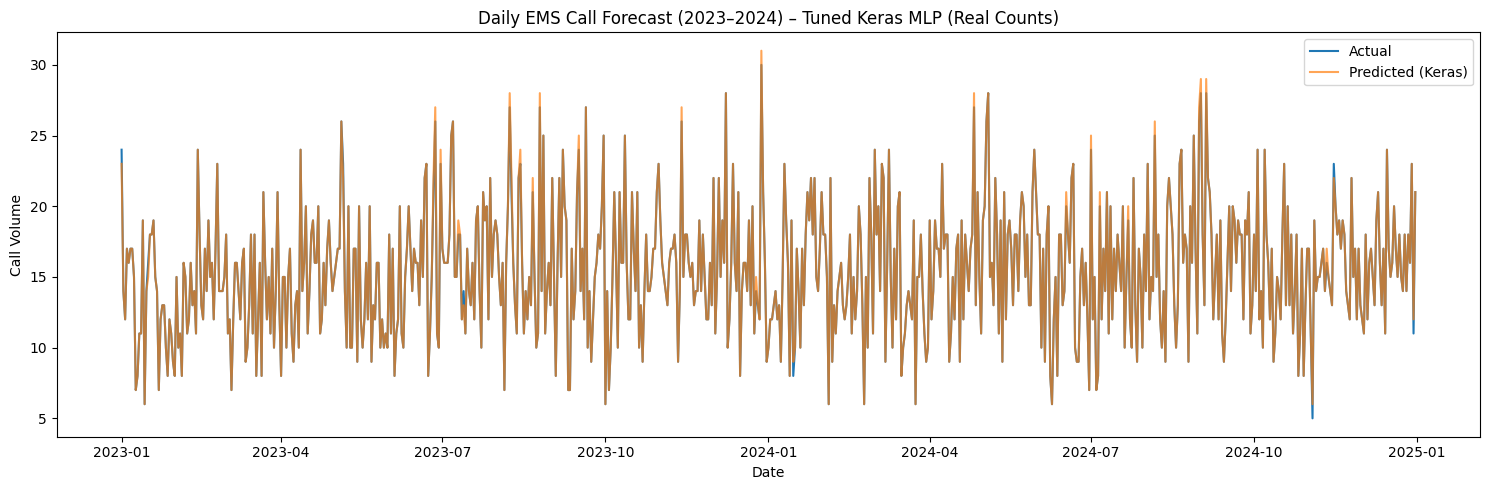

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load EMS Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 2. Calendar Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# --- 3. Lag Features ---
for lag in [1, 2, 3, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# --- 4. Holiday/Weekend Flags ---
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 5. Drop missing values ---
daily.dropna(inplace=True)

# --- 6. Define Features ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy'
]

# --- 7. Train/Test Split ---
train = daily[daily['date'] < '2023-01-01']
test = daily[daily['date'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]
y_train = train['call_volume']
y_test = test['call_volume']

# --- Same preprocessing as before up to Step 8 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- Tighter Keras MLP ---
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Predict in log space, convert to real counts ---
preds_log = model.predict(X_test_scaled).flatten()
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = y_test.round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Tuned Keras MLP RMSE (actual calls): {rmse:.2f}")

# --- Plot (real values only) ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'].values, y_test_actual.values, label='Actual')
plt.plot(test['date'].values, preds, label='Predicted (Keras)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Tuned Keras MLP (Real Counts)')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
import os

# --- 1. Load and preprocess full EMS data ---
df = pd.read_csv("../data/clean/calls_by_district.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df['hour'] = df['CallDateTime'].dt.hour
df['date'] = pd.to_datetime(df['CallDateTime'].dt.date)
df['day_of_week'] = df['CallDateTime'].dt.dayofweek
df['month'] = df['CallDateTime'].dt.month
df['year'] = df['CallDateTime'].dt.year
df['NAME'] = df['NAME'].astype(str)


def month_to_season(month):
    if month in [12, 1, 2]: return 'winter'
    if month in [3, 4, 5]: return 'spring'
    if month in [6, 7, 8]: return 'summer'
    return 'fall'


df['season'] = df['month'].apply(month_to_season)
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df['date'].min(), end=df['date'].max())
df['is_holiday'] = df['date'].isin(holidays).astype(int)

# --- 2. Compute proportion tables for each year ---
os.makedirs("proportions_by_year", exist_ok=True)

for year in [2017, 2018, 2019, 2020, 2021, 2022]:
    if year not in df['year'].values:
        continue
    print(f"Processing {year}...")
    df_year = df[df['year'] == year].copy()

    hour_totals = df_year.groupby(['date', 'hour', 'day_of_week', 'month', 'is_holiday', 'season']).size().reset_index(
        name='hourly_calls')
    daily_totals = df_year.groupby(['date']).size().reset_index(name='daily_calls')
    hour_totals = pd.merge(hour_totals, daily_totals, on='date')
    hour_totals['p_hour_given_context'] = hour_totals['hourly_calls'] / hour_totals['daily_calls']

    ph = hour_totals.groupby(['hour', 'day_of_week', 'month', 'is_holiday', 'season'])[
        'p_hour_given_context'].mean().reset_index()
    ph['context_key'] = (
            ph['day_of_week'].astype(str) + "_" +
            ph['month'].astype(str) + "_" +
            ph['is_holiday'].astype(str) + "_" +
            ph['season']
    )
    ph['p_hour_given_context'] = ph.groupby('context_key')['p_hour_given_context'].transform(lambda x: x / x.sum())

    district_counts = df_year.groupby(
        ['hour', 'NAME', 'day_of_week', 'month', 'is_holiday', 'season']).size().reset_index(name='count')
    hour_counts = df_year.groupby(['hour', 'day_of_week', 'month', 'is_holiday', 'season']).size().reset_index(
        name='total')
    pdh = pd.merge(district_counts, hour_counts, on=['hour', 'day_of_week', 'month', 'is_holiday', 'season'])
    pdh['p_d_given_h_context'] = pdh['count'] / pdh['total']

    ph.to_csv(f"proportions_by_year/ph_{year}.csv", index=False)
    pdh.to_csv(f"proportions_by_year/pdh_{year}.csv", index=False)

# --- 3. Create ensemble average of all years ---
years = [y for y in range(2017, 2023) if os.path.exists(f"proportions_by_year/ph_{y}.csv")]

ph_list = [pd.read_csv(f"proportions_by_year/ph_{y}.csv") for y in years]
ph_all = pd.concat(ph_list)
ph_avg = (
    ph_all.groupby(['hour', 'day_of_week', 'month', 'is_holiday', 'season'])['p_hour_given_context']
    .mean().reset_index()
)
ph_avg.to_csv("ensemble_ph.csv", index=False)
print("✅ Saved ensemble_ph.csv")

pdh_list = [pd.read_csv(f"proportions_by_year/pdh_{y}.csv") for y in years]
pdh_all = pd.concat(pdh_list)
pdh_avg = (
    pdh_all.groupby(['hour', 'NAME', 'day_of_week', 'month', 'is_holiday', 'season'])['p_d_given_h_context']
    .mean().reset_index()
)
pdh_avg.to_csv("ensemble_pdh.csv", index=False)
print("✅ Saved ensemble_pdh.csv")

# --- 4. Forecast from daily model ---
from sklearn.metrics import mean_squared_error

citywide_predictions = test[['date']].copy()
citywide_predictions['daily_predicted_calls'] = preds
citywide_predictions['day_of_week'] = citywide_predictions['date'].dt.dayofweek
citywide_predictions['month'] = citywide_predictions['date'].dt.month
citywide_predictions['season'] = citywide_predictions['month'].apply(month_to_season)
citywide_predictions['is_holiday'] = citywide_predictions['date'].isin(holidays).astype(int)

ph = pd.read_csv("ensemble_ph.csv")
pdh = pd.read_csv("ensemble_pdh.csv")

hour_segment_map = {
    h: 'DAY_1' if 7 <= h < 13 else 'DAY_2' if 13 <= h < 19 else 'NIGHT_1' if 19 <= h or h < 1 else 'NIGHT_2' for h in
    range(24)}

rows = []
for _, row in citywide_predictions.iterrows():
    context = (row['day_of_week'], row['month'], row['is_holiday'], row['season'])
    ph_context = ph[
        (ph['day_of_week'] == context[0]) &
        (ph['month'] == context[1]) &
        (ph['is_holiday'] == context[2]) &
        (ph['season'] == context[3])
        ]
    pdh_context = pdh[
        (pdh['day_of_week'] == context[0]) &
        (pdh['month'] == context[1]) &
        (pdh['is_holiday'] == context[2]) &
        (pdh['season'] == context[3])
        ]

    for hour in ph_context['hour'].unique():
        ph_val = ph_context[ph_context['hour'] == hour]['p_hour_given_context'].values[0]
        pdh_hour = pdh_context[pdh_context['hour'] == hour]
        pdh_hour = pdh_hour.copy()
        pdh_hour['p_d_given_h_context'] /= pdh_hour['p_d_given_h_context'].sum()

        for _, d_row in pdh_hour.iterrows():
            rows.append({
                'date': row['date'],
                'hour': hour,
                'NAME': d_row['NAME'],
                'segment': hour_segment_map[hour],
                'predicted_calls': row['daily_predicted_calls'] * ph_val * d_row['p_d_given_h_context']
            })

forecast_df = pd.DataFrame(rows)
segment_preds = forecast_df.groupby(['date', 'NAME', 'segment'])['predicted_calls'].sum().reset_index()
segment_preds['predicted_calls'] = segment_preds['predicted_calls'].round().astype(int)

# Load actuals for 2023–2024
actual_df = df[(df['CallDateTime'] >= '2023-01-01') & (df['CallDateTime'] < '2025-01-01')]
actual_df['segment'] = actual_df['hour'].map(hour_segment_map)
actuals = actual_df.groupby(['date', 'NAME', 'segment']).size().reset_index(name='actual_calls')

# Evaluate
merged = segment_preds.merge(actuals, how='left', on=['date', 'NAME', 'segment'])
merged['actual_calls'] = merged['actual_calls'].fillna(0).astype(int)
rmse = np.sqrt(mean_squared_error(merged['actual_calls'], merged['predicted_calls']))
print(f"\n📊 Final RMSE (Ensemble Model): {rmse:.2f}")


Processing 2017...
Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...
✅ Saved ensemble_ph.csv
✅ Saved ensemble_pdh.csv

📊 Final RMSE (Ensemble Model): 1.12


/var/folders/0z/d22cxjf5413996fwwtvz8s2c0000gn/T/ipykernel_72335/1305129335.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_df['segment'] = actual_df['hour'].map(hour_segment_map)
